In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches

In [3]:
ds_esm2m = xr.open_dataset('../data/processed/GFDL/hottestmonth_toes.nc')
ds_cesm2 = xr.open_dataset('../data/processed/CESM2/hottestmonth_toes.nc')

In [16]:
ds=ds_esm2m
ds_range = ds.quantile(0.9,'ensemble') - ds.quantile(0.1,'ensemble')

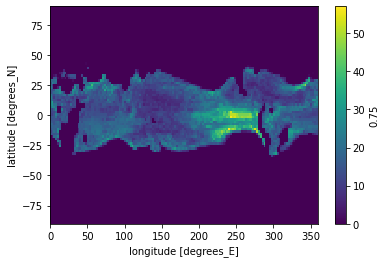

In [18]:
ds_range['0.75'].plot()